# Analysis of the SSVEP data

Let's load a couple libraries we'll use repeatedly, and set the default plot size.

In [1]:
library(dplyr, warn.conflicts=FALSE)
library(ggplot2)

options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=300)

# Setup / preprocessing

The dataframe we're about to load has already undergone fourier transform & projection to FSAverage cortical space, so we're dealing with vertex numbers and frequency bin amplitudes, across subject and pre/post intervention measurement times.  This assumes it's in the same folder as the notebook; adjust path as needed:

**NOTE:** at the end of this section, we save out the munged data, so you can skip these cells on later runs.

In [2]:
proc.time() -> start
readr::read_csv("all_subjects-fsaverage-freq_domain-stc.csv") -> all_data
print(proc.time() - start)

Parsed with column specification:
cols(
  subject = col_character(),
  freq = col_double(),
  source = col_character(),
  value = col_double(),
  timepoint = col_character()
)



   user  system elapsed 
173.861   6.275 180.144 


Now let's add in some metadata about who is in which group:

In [4]:
# load and clean metadata
readr::read_csv(file.path("..", "behavioral", "preK_InterventionData.csv")) -> metadata

metadata %>%
    rename(subject_num=subID,
           intervention=group,
           timepoint=visit) %>%
    mutate(subject_num=as.integer(subject_num)) %>%
    select(-event) ->
    metadata

print(metadata)

Parsed with column specification:
cols(
  subID = col_double(),
  event = col_character(),
  group = col_character(),
  AlphabetKnowledge = col_double(),
  Decoding = col_double(),
  PhonemeMatching = col_double(),
  PhonemeSegmenting = col_double(),
  EVTRaw = col_double(),
  Retell = col_double(),
  Grammar = col_double(),
  visit = col_character()
)



# A tibble: 96 x 10
   subject_num intervention AlphabetKnowled… Decoding PhonemeMatching
         <int> <chr>                   <dbl>    <dbl>           <dbl>
 1        1103 Language                   49        0               7
 2        1103 Language                   59        0               8
 3        1110 Language                   90        4              12
 4        1110 Language                   93        0              12
 5        1112 Letter                     23        0              12
 6        1112 Letter                     36        0              14
 7        1113 Language                   31        0               7
 8        1113 Language                   34        0               8
 9        1184 Language                   82        0              15
10        1184 Language                   89        5               8
# … with 86 more rows, and 5 more variables: PhonemeSegmenting <dbl>,
#   EVTRaw <dbl>, Retell <dbl>, Grammar <dbl>, timepoint <chr>


Let's add in a median split based on pretest variable `AlphabetKnowledge`, and make sure that it gives us equal-sized groups.

In [5]:
metadata %>%
    filter(timepoint == "pre") %>%
    mutate(pretest=ifelse(AlphabetKnowledge < median(AlphabetKnowledge), "lower", "upper")) %>%
    select(subject_num, pretest) %>%
    right_join(metadata, by="subject_num") ->
    metadata

metadata %>% group_by(pretest) %>% count()

pretest,n
<chr>,<int>
lower,48
upper,48


Next we'll define a function that will compute noise (the mean of the 2 frequency bins below and 2 frequency bins above the current bin). We'll apply it within a `group_by` operation 

In [6]:
# function to compute noise (mean of 2 bins above and below)
compute_noise <- function(x) {
    (lag(x, 2, 0) + lag(x, 1, 0) + lead(x, 1, 0) + lead(x, 2, 0)) / 4
}

Now we'll merge in the metadata, separate the `source` column into separate hemisphere and vertex number columns, and compute `noise` and `snr` all in one go.

In [7]:
# this takes several minutes... might be worth it to split it into steps that assign back to `all_data`
# the comment lines are natural points at which to do this.
all_data %>%
    # merge in metadata
    mutate(subject_num=as.integer(stringr::str_sub(subject, -4))) %>%
    left_join(metadata, by=c("subject_num", "timepoint")) %>%
    # separate the hemispheres
    tidyr::separate(source, c("hemi", "vertex"), sep="_") %>%
    mutate(hemi=stringr::str_to_lower(hemi),
           vertex=as.integer(vertex),
           source=NULL) %>%
    # compute noise and SNR
    group_by(subject_num, timepoint, hemi, vertex) %>%
    mutate(noise=compute_noise(value),
           snr=value/noise) %>%
    ungroup() ->
    all_data

Now that our dataframe has all the variables we want, let's compute our (uncorrected) t-test of "signal bin" vs "mean of adjacent noise bins". This will yield a new dataframe with the t-test results.

In [8]:
# compute signal-vs-noise uncorrected t-test
all_data %>%
    filter(freq == 2, timepoint == "pre") %>%
    group_by(hemi, vertex) %>%
    do(broom::tidy(t.test(.$value, .$noise, paired=TRUE))) ->
    tvals

Now we merge the t-values back into the main dataframe, so we can use them to filter the data.

In [9]:
# merge t-values back into main dataframe
all_data %>%
    left_join(tvals, by=c("hemi", "vertex")) ->
    all_data

Now we save the preprocessing work, so we don't have to do it every time:

In [10]:
save(all_data, file="processed_data_with_tvals.RData")

## Start here if skipping the preprocessing section
Optional save/load point:

In [11]:
# load("processed_data_with_tvals.RData")

# Looking at the frequency spectrum across the brain

Let's take a look at the average power spectrum across all vertices and subjects. The target frequencies are 2 Hz and 6 Hz, but we'll also highlight harmonics at 4, 12, and 18 Hz. Since this is a 2-panel plot we'll make it wider than usual.

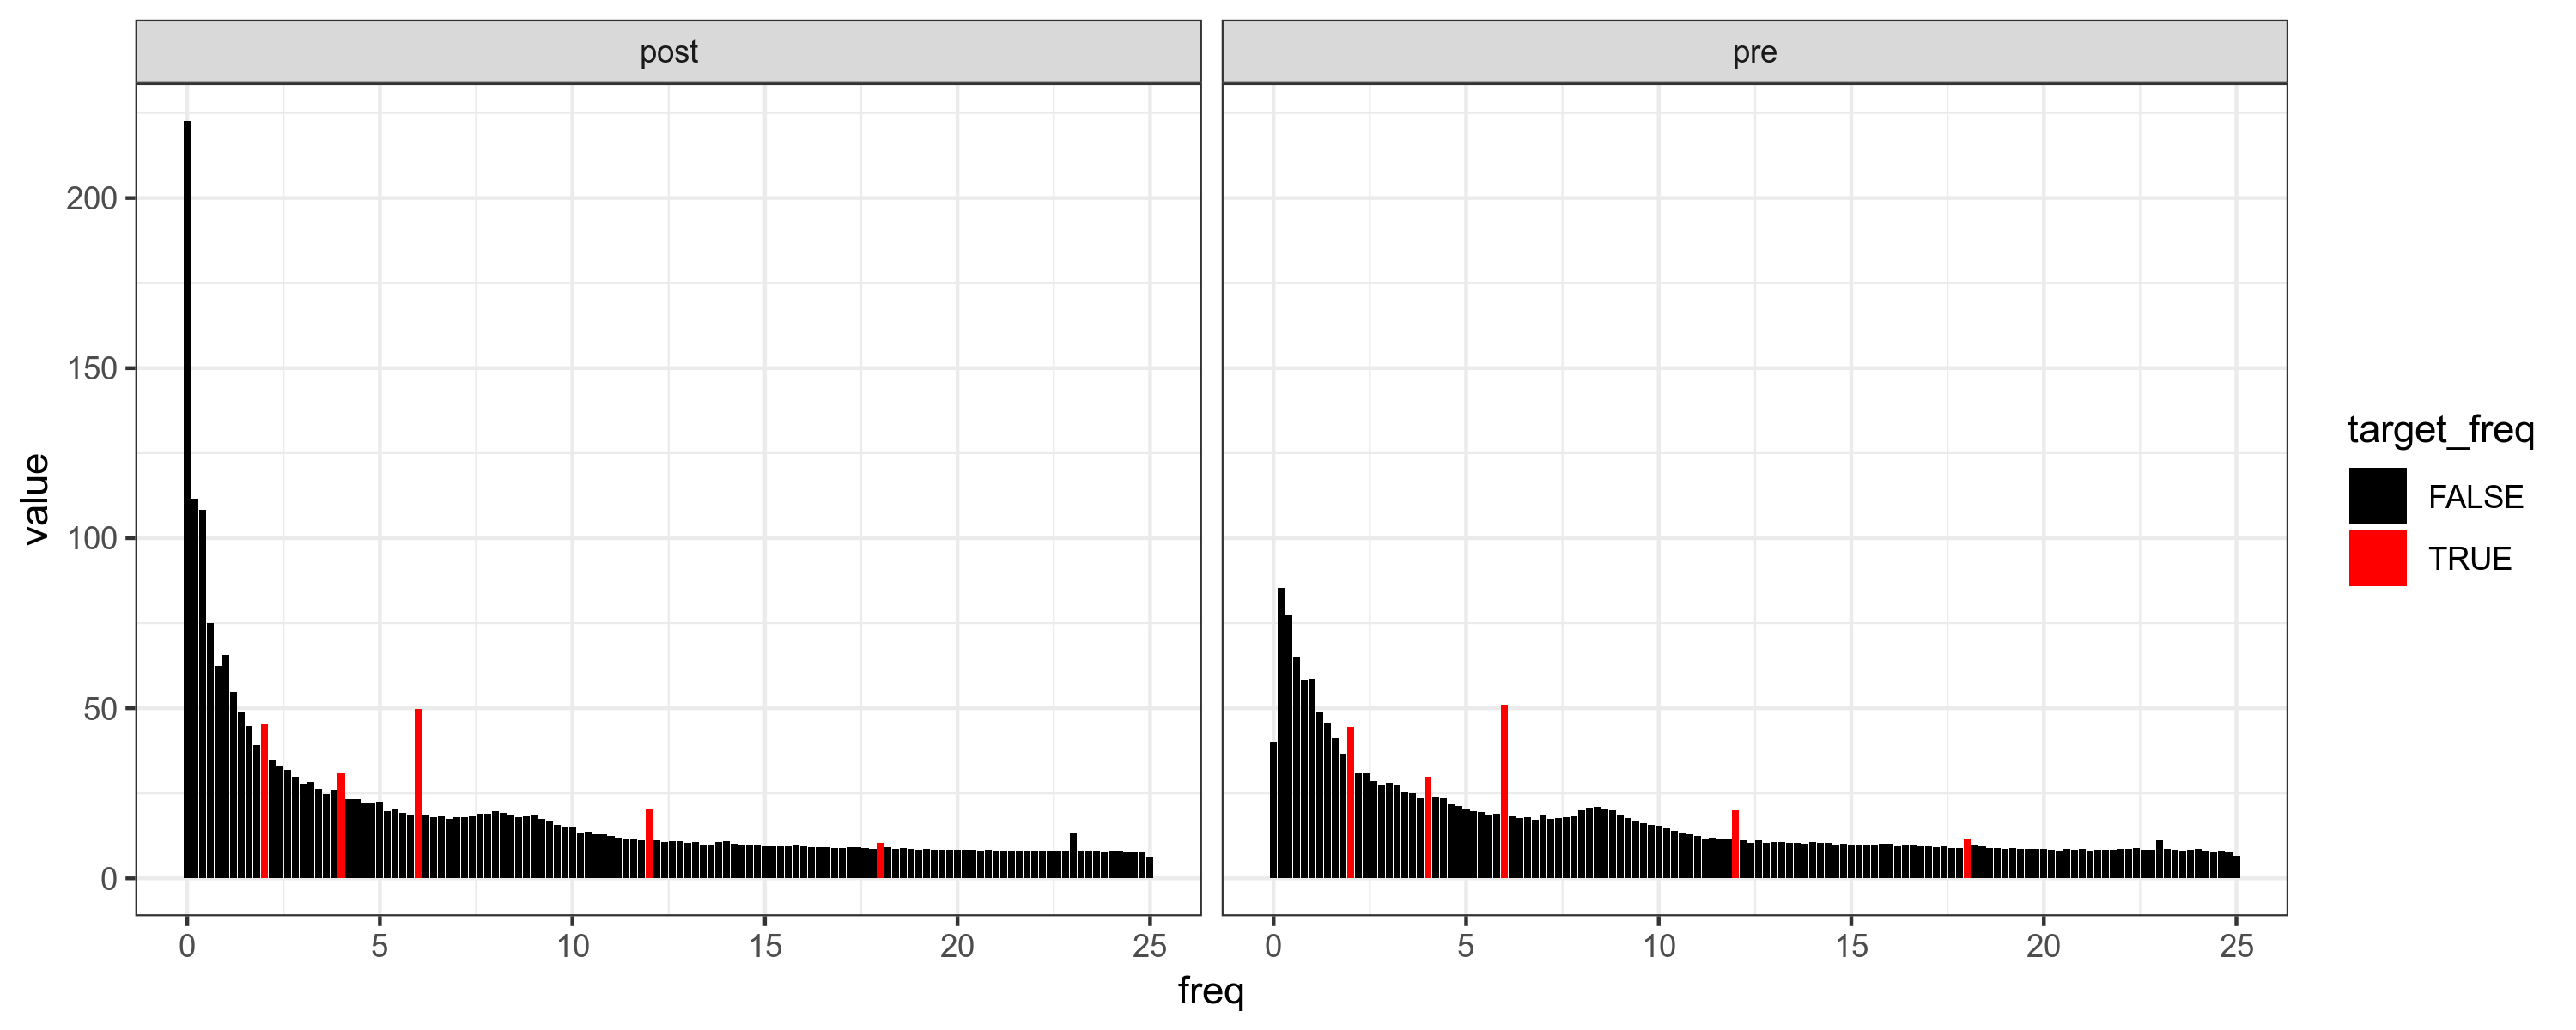

In [12]:
options(repr.plot.width=10)

all_data %>%
    group_by(timepoint, freq) %>%
    summarise(value=mean(value)) %>%
    mutate(target_freq=freq %in% c(2, 4, 6, 12, 18)) %>%
    ggplot(aes(x=freq, y=value, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat='identity') +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

OK, typical $\frac{1}{f}$ shape, with our target frequencies (and their harmonics) poking out. Let's flatten out the spectrum by looking at SNR instead of raw amplitude in each bin:

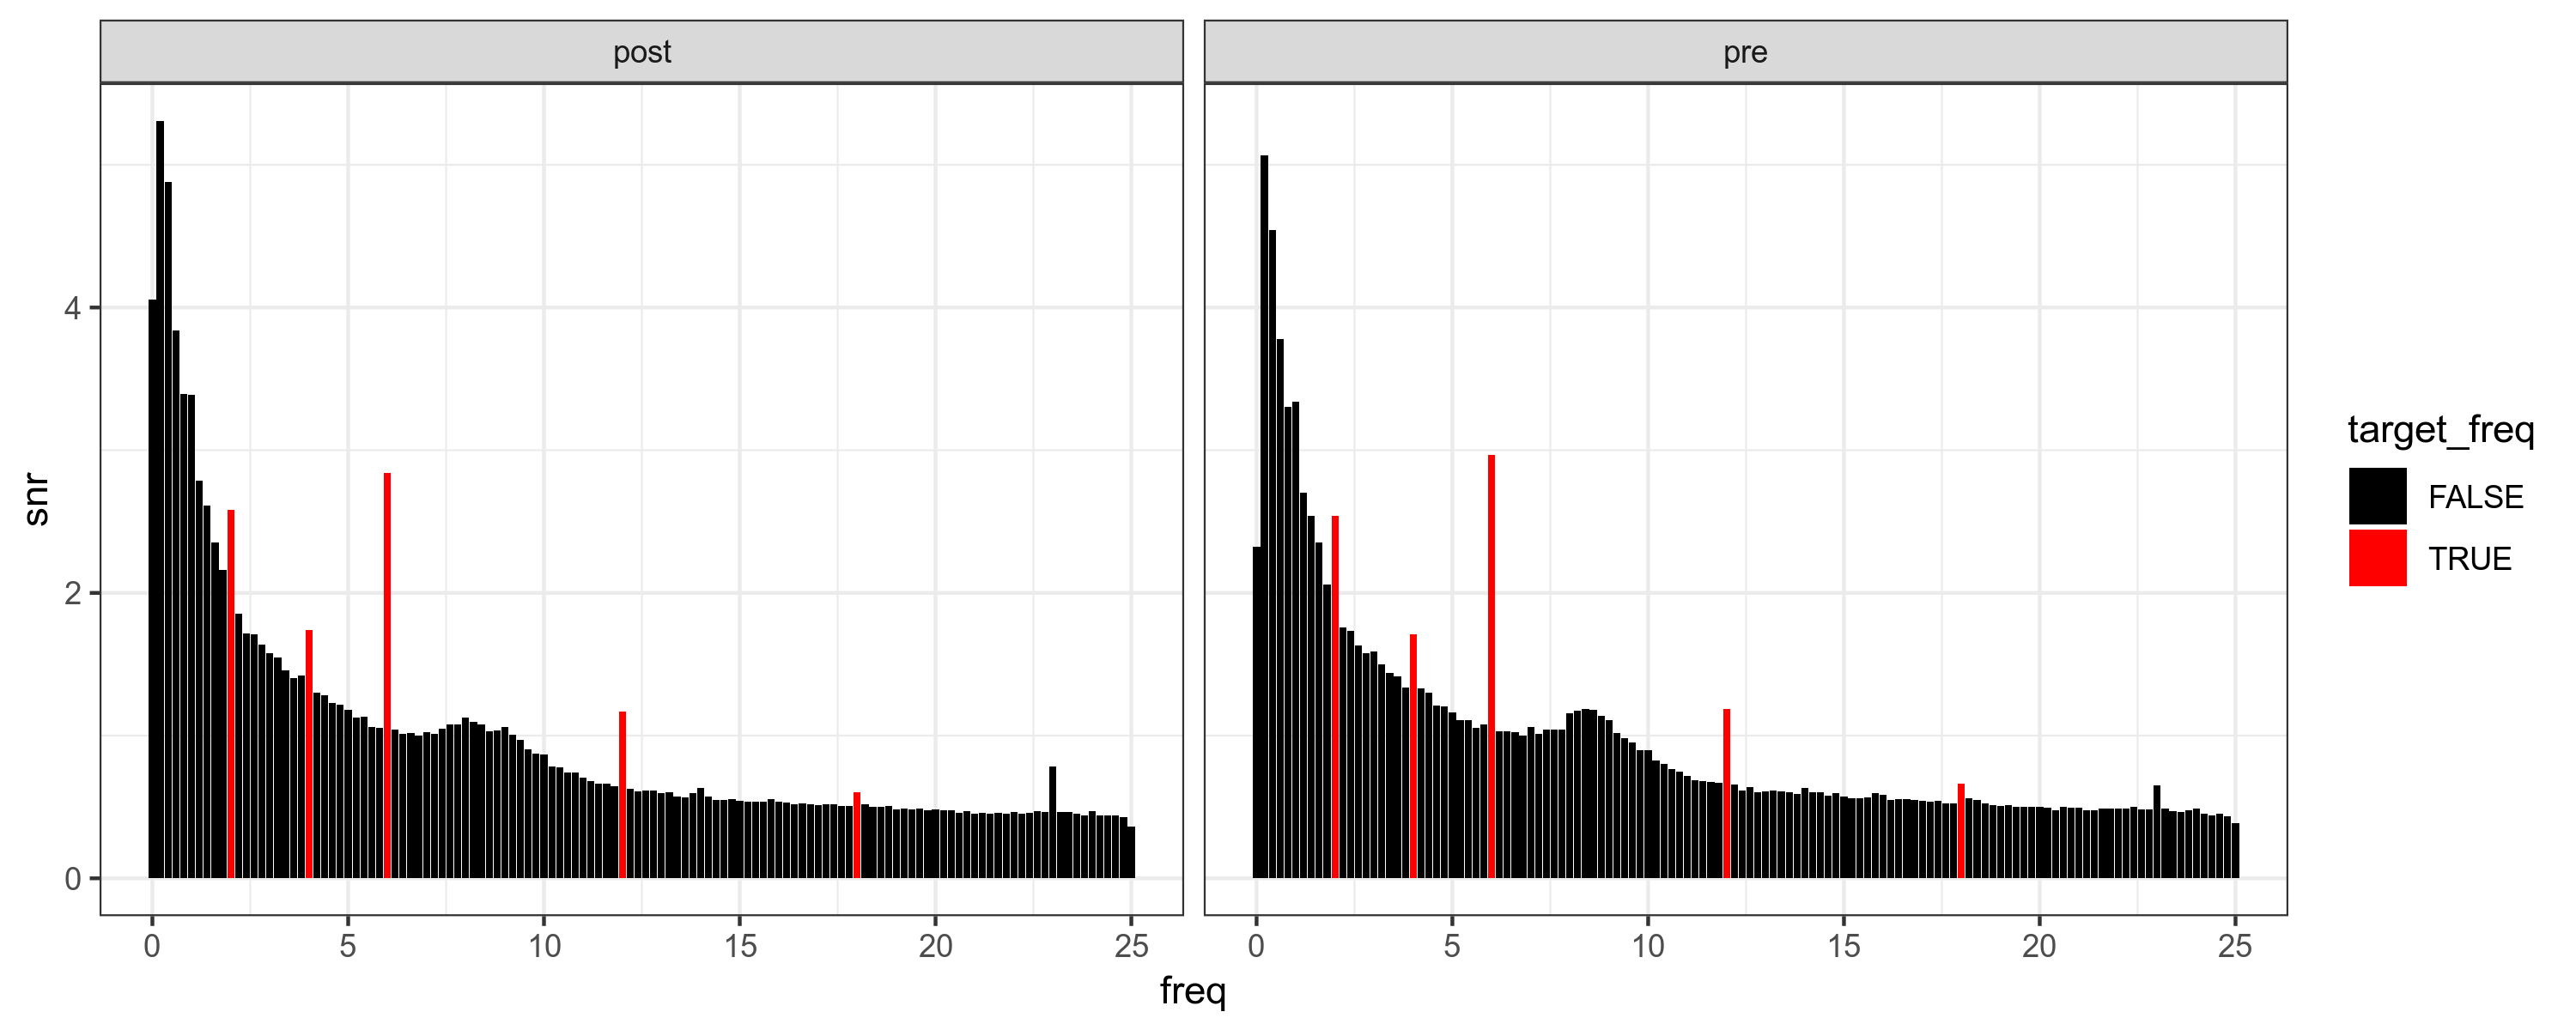

In [13]:
all_data %>%
    group_by(timepoint, freq) %>%
    summarise(snr=mean(snr)) %>%
    mutate(target_freq=freq %in% c(2, 4, 6, 12, 18)) %>%
    ggplot(aes(x=freq, y=snr, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat='identity') +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

The large values near the edges are expected based on how we calculate noise, but the spike at 23 Hz (which is bigger in the post-intervention data) is a bit of a mystery.

# Creating an ROI based on 2 Hz response

The 2 Hz response is what we care most about, so let's use it to filter on t-values greater than 4, and use that as our ROI for comparing the 2 Hz response in our
cohorts:

In [14]:
all_data %>%
    filter(statistic >= 4, freq == 2) %>%
    group_by(subject_num, timepoint, pretest, intervention) %>%
    summarise(activation=mean(value)) ->
    mean_in_roi

print(mean_in_roi)

# A tibble: 96 x 5
# Groups:   subject_num, timepoint, pretest [96]
   subject_num timepoint pretest intervention activation
         <int> <chr>     <chr>   <chr>             <dbl>
 1        1103 post      lower   Language           49.3
 2        1103 pre       lower   Language           43.7
 3        1110 post      upper   Language           33.3
 4        1110 pre       upper   Language           48.2
 5        1112 post      lower   Letter             82.9
 6        1112 pre       lower   Letter             40.2
 7        1113 post      lower   Language           42.4
 8        1113 pre       lower   Language           53.2
 9        1184 post      upper   Language           50.8
10        1184 pre       upper   Language           67.5
# … with 86 more rows


## whole-brain t-test of pre-intervention letter awareness

Now let's do a t-test comparing two groups (median split on the pre-intervention letter awareness test):

In [15]:
mean_in_roi %>%
    filter(timepoint == "pre") %>%
    t.test(activation ~ pretest, data=.) ->
    pretest_tvals

print(pretest_tvals)


	Welch Two Sample t-test

data:  activation by pretest
t = 0.20228, df = 40.015, p-value = 0.8407
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -9.106589 11.132179
sample estimates:
mean in group lower mean in group upper 
           45.19234            44.17954 



## whole-brain t-test of intervention effect

And now for the intervention effect. What we care about here is *change* in activation pre-versus-post intervention, so we'll need to do a `post - pre` subtraction first:

In [17]:
mean_in_roi %>%
    tidyr::pivot_wider(names_from=timepoint, values_from=activation, id_cols=c(subject_num, intervention)) %>%
    mutate(post_minus_pre=post - pre) %>%
    t.test(post_minus_pre ~ intervention, data=.) ->
    intervention_tvals

print(intervention_tvals)


	Welch Two Sample t-test

data:  post_minus_pre by intervention
t = -2.5699, df = 45.134, p-value = 0.01354
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -25.760324  -3.124602
sample estimates:
mean in group Language   mean in group Letter 
             -6.177396               8.265067 



## separate t-tests for each hemisphere

So far our ROI was based on a t-value threshold across the whole brain.  Let's separate the ROI by hemisphere to see if the differences are asymmetric:

In [18]:
all_data %>%
    filter(statistic >= 4, freq == 2) %>%
    group_by(subject_num, timepoint, pretest, intervention, hemi) %>%
    summarise(activation=mean(value)) ->
    separate_hemi_roi

print(separate_hemi_roi)

# A tibble: 192 x 6
# Groups:   subject_num, timepoint, pretest, intervention [96]
   subject_num timepoint pretest intervention hemi  activation
         <int> <chr>     <chr>   <chr>        <chr>      <dbl>
 1        1103 post      lower   Language     lh          50.1
 2        1103 post      lower   Language     rh          48.5
 3        1103 pre       lower   Language     lh          41.2
 4        1103 pre       lower   Language     rh          46.2
 5        1110 post      upper   Language     lh          37.6
 6        1110 post      upper   Language     rh          28.9
 7        1110 pre       upper   Language     lh          52.6
 8        1110 pre       upper   Language     rh          43.7
 9        1112 post      lower   Letter       lh          91.8
10        1112 post      lower   Letter       rh          73.8
# … with 182 more rows


In [19]:
separate_hemi_roi %>%
    filter(timepoint == "pre") %>%
    group_by(hemi) %>%
    do(broom::tidy(t.test(activation ~ pretest, data=.))) ->
    pretest_tvals_by_hemi

pretest_tvals_by_hemi

hemi,estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
lh,-2.145118,42.47548,44.62060,-0.4990251,0.6201923,45.00574,-10.802949,6.512712,Welch Two Sample t-test,two.sided
rh,4.275514,47.99937,43.72385,0.7177922,0.4775213,35.97242,-7.805106,16.356134,Welch Two Sample t-test,two.sided


In [21]:
separate_hemi_roi %>%
    tidyr::pivot_wider(names_from=timepoint, values_from=activation, id_cols=c(subject_num, intervention, hemi)) %>%
    mutate(post_minus_pre=post - pre) %>%
    group_by(hemi) %>%
    do(broom::tidy(t.test(post_minus_pre ~ intervention, data=.))) ->
    intervention_tvals_by_hemi

intervention_tvals_by_hemi

hemi,estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
lh,-12.62866,-4.621358,8.007300,-2.331822,0.02415218,45.91598,-23.53062,-1.726702,Welch Two Sample t-test,two.sided
rh,-16.31646,-7.785076,8.531388,-2.499098,0.01613492,45.38523,-29.46335,-3.169582,Welch Two Sample t-test,two.sided


# Regression against granular metadata

Let's take a look now at the relationship between the pre-test variables and the average 2 Hz response.

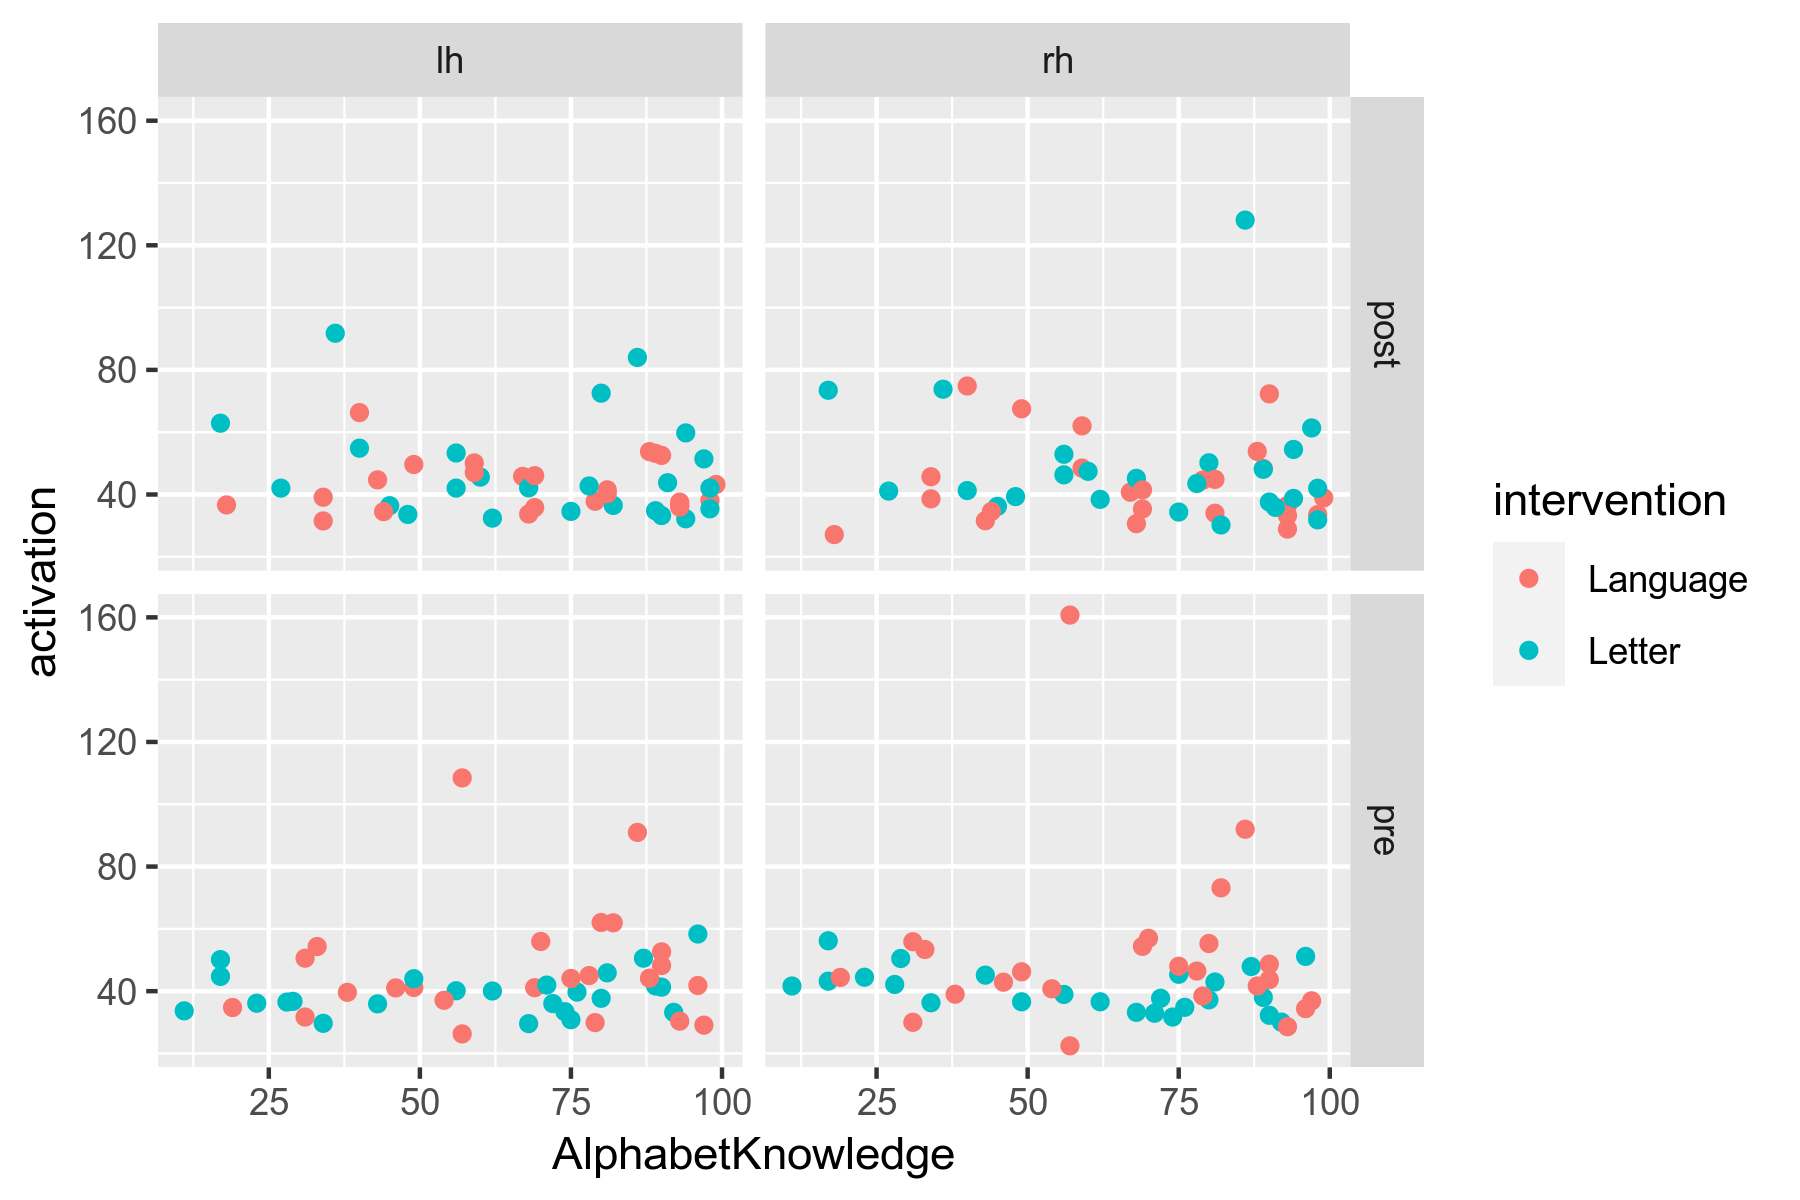

In [22]:
options(repr.plot.width=6)

separate_hemi_roi %>%
    left_join(metadata, by=c("subject_num", "timepoint", "pretest", "intervention")) %>%
    ggplot(aes(x=AlphabetKnowledge, y=activation, colour=intervention)) + 
    facet_grid(timepoint ~ hemi) + 
    geom_point()